*Warning*: As we use functions from the MSc thesis this Notebook has to be located in the folder which contains the code, or otherwise define the path to thatcode*. We vary slightly the cowell function (here named cowell2) so that we can give an initial time t0. As cowell only gives the final state and some control laws depend explicitly on the time, if we wish to compute succesive steps we need this. Maybe there already exists a function for this but I've not found it.

In [103]:
import pytest
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from numpy.testing import assert_allclose
from scipy.integrate import ode,odeint
from astropy import units as u

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter
from poliastro.plotting import plot
import matplotlib.pyplot as plt
plt.ion()
from edelbaum import guidance_law, extra_quantities

from poliastro.twobody.propagation import func_twobody

def cowell2(k, r0, v0, tof, rtol=1e-10, *, ad=None, callback=None, nsteps=1000,t0 = 0):
    """Propagates orbit using Cowell's formulation.

    Parameters
    ----------
    k : float
        Gravitational constant of main attractor (km^3 / s^2).
    r0 : array
        Initial position (km).
    v0 : array
        Initial velocity (km).
    ad : function(t0, u, k), optional
         Non Keplerian acceleration (km/s2), default to None.
    tof : float
        Time of flight (s).
    rtol : float, optional
        Maximum relative error permitted, default to 1e-10.
    nsteps : int, optional
        Maximum number of internal steps, default to 1000.
    callback : callable, optional
        Function called at each internal integrator step.
    t0 : float
        Initial time
    ------
    RuntimeError
        If the algorithm didn't converge.

    Notes
    -----
    This method uses a Dormand & Prince method of order 8(5,3) available
    in the ``scipy.integrate.ode`` module.

    """
    x, y, z = r0
    vx, vy, vz = v0
    u0 = np.array([x, y, z, vx, vy, vz])

    # Set the non Keplerian acceleration
    if ad is None:
        ad = lambda t0, u_, k_: (0, 0, 0)
        
        

    # Set the integrator
    rr = ode(func_twobody).set_integrator('dop853', rtol=rtol, nsteps=nsteps)
    rr.set_initial_value(u0,t0)  # Initial time equal to t0
    rr.set_f_params(k, ad)  # Parameters of the integration
    if callback:
        rr.set_solout(callback)

    # Make integration step
    rr.integrate(tof)

    if rr.successful():
        r, v = rr.y[:3], rr.y[3:]
    else:
        raise RuntimeError("Integration failed")

    return r, v



In the folowing two cells the code is mainly recycled from the MSc thesis code, sith some slight differences to get intermediate states

In [88]:
# Problem data
f = 3.5e-7  # km / s2

a_0 = 7000.0  # km
a_f = 42166.0  # km
inc_f = 0.0  # rad
inc_0 = np.radians(28.5) #rad
k = Earth.k.decompose([u.km, u.s]).value

In [89]:
edelbaum_accel = guidance_law(k, a_0, a_f, inc_0, inc_f, f)

_, t_f = extra_quantities(k, a_0, a_f, inc_0, inc_f, f)

# Retrieve r and v from initial orbit
s0 = Orbit.circular(Earth, a_0 * u.km - Earth.R, inc_0 * u.rad)
r0, v0 = s0.rv()

n_s = 100 #number of substeps
rs = np.zeros((n_s + 1,3)) #this are the variables where we will store the intermediate states
vs = np.zeros((n_s + 1,3))

t_fs = t_f / n_s
rs[0] = r0.to(u.km).value
vs[0] = v0.to(u.km / u.s).value

# Propagate orbit in n_s steps
for i in range(n_s):
    r, v = cowell2(k,
                  rs[i],
                  vs[i],
                  (i+1)*t_fs,
                  ad=edelbaum_accel,
                  nsteps=1000000,
                  t0 = i*t_fs)

    rs[i+1] = r 
    vs[i+1] = v

Now we plot the osculant orbits for the intermediate steps

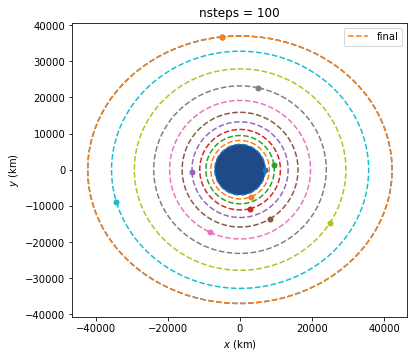

In [94]:
ss = [Orbit.from_vectors(Earth,rs[i] * u.km,vs[i] * u.km / u.s,s0.epoch + t_f * u.s) for i in range(0,101,10)]

sf = Orbit.from_vectors(Earth,
                        r * u.km,
                        v * u.km / u.s,
                        s0.epoch + t_f * u.s)

s0 = Orbit.circular(Earth, a_0 * u.km - Earth.R, inc_0* u.rad)

op = OrbitPlotter()

for s in ss:
      op.plot(s)

op.plot(sf,label = "final")
plt.title("nsteps = 100")

This can also be done in 3D (as I'm not still totally familiar with the poliastro propagating functions, I've rather compute the orbits using _integrate.scipy.odeint_)

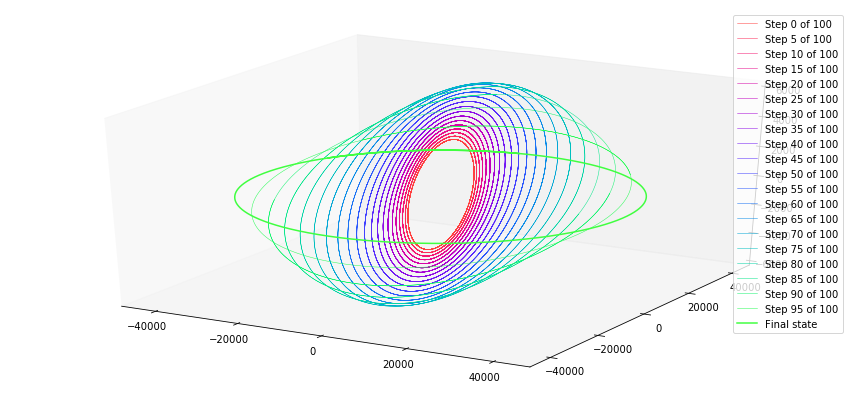

In [95]:
def hue(t): #color oscillations for the plot, not important
    def funcion(t):
        omega = 1
        return np.sin(np.pi*omega*t)**2
    inc0 = 0
    inc1 = 1/3
    inc2 = -1/3
    return (funcion(t + inc0),funcion(t + inc1),funcion(t + inc2))

t0 = np.linspace(0,100000,10000)
us = [] #here we will store the orbits for different i's
for i in range(n_s + 1):
    u0 = np.zeros(6)
    u0[:3] = rs[i]
    u0[3:] = vs[i]
    
    def f_twobody(u0,t0):   #I needed an auxiliary function for usint odeint; I expect to learn how to do this 
                            #efficiently with poliastro
        def f_zero(t,u,k):
            return (0,0,0)
        return func_twobody(t0,u0,k,f_zero)
    
    u = odeint(f_twobody,u0,t0)
    us.append(u)

fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(111,projection = '3d')

for i in range(0,100,5):
    plt.plot(us[i][:,0],us[i][:,1],us[i][:,2],label = 'Step '+str(i)+' of 100',linewidth = 0.5,alpha = 1,c = hue(0.5 + float(i)/150))

i = 100
plt.plot(us[i][:,0],us[i][:,1],us[i][:,2],label = 'Final state',linewidth = 1.5,alpha = 1,c = hue(0.5 + float(i)/150))

ax.legend()
ax.grid(False)
plt.show()

This could be a posibility for the _lowthrust_ function,though it is still a bit "ortopedical" and a better solution can be thought if I am elected.

In [106]:
def low_thrust(s_0,f,a_f = 0,inc_f = 0,other_arguments = None):
    """Parametrized control law to perform a specific change in orbit.

    This function takes an initial Orbit and the module (constant) of our  acceleration and 
    returns the guidance law to perform a specific change in one (or more) elements of the Orbit.
    
    The change in the orbital elements are by default 0. The algorithm will only a_0,work if the set of
    non-zero arguments fits one of the guidance law that are already implemented. Thus it will be easy 
    to expand the algorithm.

    Parameters
    ----------
    t0 : Orbit
        Initial orbit.
    f  : float
        Module of the available acceleration.
    a_f : float (optional)
        Final semimajor axis
    inc_f : float (optional)
        Final inclination

    """
    a_0 = s_0.a
    ecc_0 = s_0.ecc
    inc_0 = s_0.inc
    raan_0 = s_0.raan
    argp_0 = s_0.argp
    nu_0 = s_0.nu
    
    a_0v = s_0.a.value
    ecc_0v = s_0.ecc.value
    inc_0v = s_0.inc.value
    raan_0v = s_0.raan.value
    argp_0v = s_0.argp.value
    nu_0v = s_0.nu.value
    
    
    if a_f - a_0v != 0:
        if inc_f - inc_0v != 0:   #this has to change in order to allow different attractors
            edelbaum_accel = guidance_law(k, a_0v, a_f, inc_0v, inc_f, f) #this should change its name
                                                    #very soon, as more guidance laws are implemented
            delta_V, t_f = extra_quantities(k, a_0v, a_f, inc_0v, inc_f, f)
            
            ecc_f = s_0.ecc
            raan_f= s_0.raan
            argp_f = s_0.argp
            nu_f = s_0.nu
            
            a_f = a_f * u.km
            inc_f = inc_f*u.radian
            
            s_f = Orbit.from_classical(s_0.attractor,a_fv,ecc_f,inc_f,raan_f,argp_f,nu_f)
            
            return s_f,delta_V, t_f, edelbaum_accel

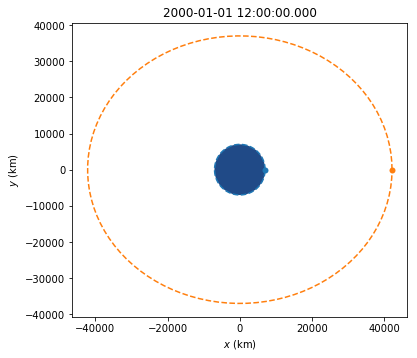

In [107]:
s_f,delta_V, t_f, edelbaum_accel = low_thrust(s0,f,a_f,inc_f)

op = OrbitPlotter()
op.plot(s0)
op.plot(s_f)


42166.0